Tutorial for preprocessing the sample GPS data <br>
 Includes smoothing and pre-processing

Imports

In [1]:
import os 
import seaborn as sns
import folium
import numpy as np
import matplotlib.pyplot as plt

# import custom functions
os.chdir('..')
from RuckFunctions import DataLoading, Preprocessing

Load data

In [3]:
# Initialize path to data (UTM-converted datasets)
data_dir = os.getcwd() + '\\SampleData'

# Load datasets (just a couple)
raw_datasets = DataLoading.load_data(data_dir)[:2]

# Re-shape datasets
datasets = DataLoading.pivot_datsets(raw_datasets)

Get the interpolated data

In [4]:
# get interpolated datasets
interp_datasets = Preprocessing.interpolate_datasets(datasets, threshold = 0.99)

Get movement periods


In [5]:
# get slices for movement periods and break times   
rucks_bySquad, rests_bySquad, all_stops = Preprocessing.get_slices_byArea(interp_datasets, plot=False)

Get an example squad's data

In [6]:
rucks = rucks_bySquad[1]

Get the smoothed data
<br>
The smoothing parameter (s) will be different for longitude/latitude and for UTM coordinates


In [7]:
smooth_rucks_UTM = Preprocessing.spline_smoothing(rucks, s=3e1 , UTM=True )
smooth_rucks_LAT = Preprocessing.spline_smoothing(rucks, s=3e-9, UTM=False)

Plot smoothed vs raw sample path (30 seconds)

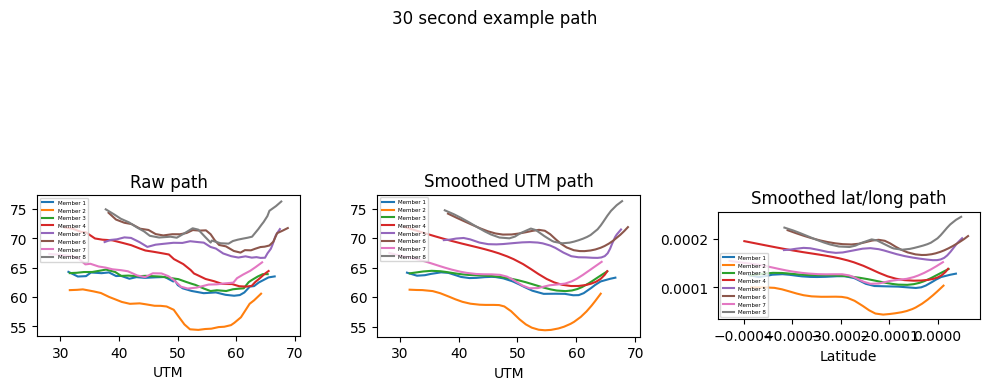

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))

# plot raw (interpolated) paths
for name in rucks[0].UTM_x.columns:
    rucks[0][100:130].plot(ax=ax[0], x=('UTM_x', name), y=('UTM_y', name), label=name)
ax[0].set_aspect(1)
ax[0].set_title('Raw path')
ax[0].set_xlabel('UTM')
ax[0].legend(fontsize=4)

# plot smooth UTM paths
for name in smooth_rucks_UTM[0].UTM_x.columns:
    smooth_rucks_UTM[0][100:130].plot(ax=ax[1], x=('UTM_x', name), y=('UTM_y', name), label=name)
ax[1].set_aspect(1)
ax[1].set_title('Smoothed UTM path')
ax[1].set_xlabel('UTM')
ax[1].legend(fontsize=4)

# plot smooth coordinate paths
for name in smooth_rucks_LAT[0].latitude.columns:
    smooth_rucks_LAT[0][100:130].plot(ax=ax[2], x=('longitude', name), y=('latitude', name), label=name)
ax[2].set_aspect(1)
ax[2].set_title('Smoothed lat/long path')
ax[2].set_xlabel('Latitude')
ax[2].legend(fontsize=4)

# get rid of offset values on axis labels
for axes in ax:
    plt.setp(axes.get_xaxis().get_offset_text(), visible=False)
    plt.setp(axes.get_yaxis().get_offset_text(), visible=False)

# add title
plt.suptitle('30 second example path')
plt.tight_layout()



Make the full dataset smooth to show on the map
<br>
Include an over-smoothed example
<br>(no movement period separation)

In [14]:
smooth_full_datasets = Preprocessing.spline_smoothing(interp_datasets, s=3e-9, UTM=False)
extra_smooth_full_datasets = Preprocessing.spline_smoothing(interp_datasets, s=3e-5, UTM=False)

Get an example individual's full dataset

In [15]:
sample_name = interp_datasets[1].latitude.columns[0]
print('example name: ' + sample_name)

interp_data = interp_datasets[1][[c for c in interp_datasets[1].columns if sample_name in c]]
smooth_data = smooth_full_datasets[1][[c for c in smooth_full_datasets[1].columns if sample_name in c]]
extra_smooth_data = extra_smooth_full_datasets[1][[c for c in smooth_full_datasets[1].columns if sample_name in c]]

example name: Member 1


Plot an interactive folium map with extra smoothed and raw data
<br>
Toggle each path with the button in the top right corner

In [16]:
m = folium.Map(
    # location = [42.49079459046541, -71.66046870896011],
    location = [42.4942, -71.6582],
    zoom_start=13.5,
    tiles='OpenStreetMap',
    width=1024,
    height=768,
    control_scale = True
)

feature_group_raw = folium.FeatureGroup(name='Raw')
folium.PolyLine(interp_data[['latitude', 'longitude']], color='#842976', smooth_factor=0, tooltip="Raw").add_to(feature_group_raw)

feature_group_smoothed = folium.FeatureGroup(name='Semi-Smoothed')
folium.PolyLine(smooth_data[['latitude', 'longitude']], color='#8DCA46', smooth_factor=0, tooltip="Semi-Smoothed").add_to(feature_group_smoothed)

feature_group_Xsmoothed = folium.FeatureGroup(name='Over-Smoothed')
folium.PolyLine(extra_smooth_data[['latitude', 'longitude']], color='#00875D', smooth_factor=0, tooltip="Over-Smoothed").add_to(feature_group_Xsmoothed)

# get this soldier
feature_group_raw.add_to(m)
feature_group_smoothed.add_to(m)
feature_group_Xsmoothed.add_to(m)

# add layer control to map
m.add_child(folium.map.LayerControl())

display(m)